# Creating training, validation and test sets

In [7]:
from os import mkdir
import glob
import random
import shutil

In [8]:
VAL_SIZE = 0.15
TEST_SIZE = 0.2

In [9]:
train_images = []
val_images = []
test_images = []

In [10]:
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [11]:
orig_path = "../input/flowers-recognition/flowers/"
train_path = "../working/train"
val_path = "../working/validation"
test_path = "../working/test"

mkdir(train_path)
mkdir(val_path)
mkdir(test_path)

In [12]:
f = []
dirs = []

for c in classes:
    img_list = glob.glob(orig_path + "/" + c + "/*.jpg")
    
    val_images = random.sample(img_list, int(VAL_SIZE * len(img_list)))
    img_list = [f for f in img_list if f not in val_images]
    test_images = random.sample(img_list, int(TEST_SIZE * len(img_list)))
    train_images = [f for f in img_list if f not in test_images]
    
    mkdir(train_path + "/" + str(c))
    mkdir(val_path + "/" + str(c))
    mkdir(test_path + "/" + str(c))
    
    for f in train_images:
        shutil.copy(f, train_path + "/" + str(c))
    
    for f in val_images:
        shutil.copy(f, val_path + "/" + str(c))
    
    for f in test_images:
        shutil.copy(f, test_path + "/" + str(c))

# Model Training

In [19]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from time import time

import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3

In [14]:
TRAIN_DIR = "/kaggle/working/train"
VALID_DIR = "/kaggle/working/validation"
IMG_SIZE = (229,229,3)
BATCH_SIZE = 32

In [15]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  rescale=1./225)
val_datagen = ImageDataGenerator(rescale=1./225)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(IMG_SIZE[0], IMG_SIZE[1]), 
    batch_size=BATCH_SIZE, 
    class_mode="categorical")

val_gen = val_datagen.flow_from_directory(
    VALID_DIR, 
    target_size=(IMG_SIZE[0], IMG_SIZE[1]), 
    batch_size=BATCH_SIZE, 
    class_mode="categorical")

Found 2944 images belonging to 5 classes.
Found 646 images belonging to 5 classes.


In [17]:
image_list = []
y_list = []
for c in classes:
    image_list.extend(glob.glob(VALID_DIR + "/" + c + "/*.jpg"))
    y_list.extend([classes.index(c)] * len(glob.glob(VALID_DIR + "/" + c + "/*.jpg")))
    
print(len(image_list), len(y_list))

646 646


In [20]:
val_images = []
for im in image_list:
    img = image.load_img(im, target_size=(224,224))
    img_arr = image.img_to_array(img)
    img_arr /= 225.
    val_images.append(img_arr)
    
X_arr = np.array(val_images)
y_arr = np.array(to_categorical(y_list))

print(X_arr.shape, y_arr.shape)

(646, 224, 224, 3) (646, 5)


In [21]:
inp = Input(IMG_SIZE)
inception = InceptionV3(include_top=False, 
                        weights='imagenet', 
                        input_tensor=inp, 
                        input_shape = IMG_SIZE, 
                        pooling = 'avg')

x = inception.output
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.1)(x)
out = Dense(5, activation='softmax')(x)

complete_model = Model(inp, out)

87916544/87910968 [==============================] - 1s 0us/step


In [28]:
complete_model.compile(loss = 'categorical_crossentropy', 
                       optimizer = 'adam', 
                       metrics = ['accuracy'])

In [29]:
complete_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 229, 229, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 114, 114, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 114, 114, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [24]:
complete_model.save("/kaggle/working/VisualizationModel.keras")

In [25]:
!pip install livelossplot

     |████████████████████████████████| 496 kB 1.3 MB/s eta 0:00:01
  Created wheel for tornado: filename=tornado-6.0.4-cp37-cp37m-linux_x86_64.whl size=428634 sha256=6db9eea49a7234349edb9041758a18458e49cc5f41b16dc11426cedcbd1d0d31
  Stored in directory: /root/.cache/pip/wheels/7d/14/fa/d88fb5da77d813ea0ffca38a2ab2a052874e9e1142bad0b348
Successfully built tornado
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

jupyterlab-git 0.10.0 requires nbdime<2.0.0,>=1.1.0, but you'll have nbdime 2.0.0 which is incompatible.
dask-xgboost 0.1.11 requires xgboost<=0.90, but you'll have xgboost 1.2.0 whic

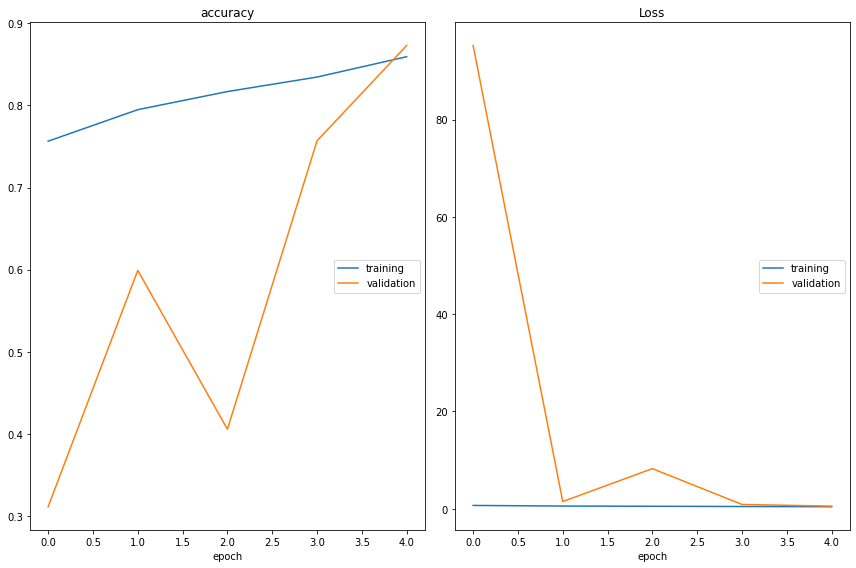

accuracy
	training         	 (min:    0.756, max:    0.859, cur:    0.859)
	validation       	 (min:    0.311, max:    0.873, cur:    0.873)
Loss
	training         	 (min:    0.426, max:    0.693, cur:    0.426)
	validation       	 (min:    0.548, max:   95.220, cur:    0.548)
92/92 [==============================] - 49s 538ms/step - loss: 0.4259 - accuracy: 0.8594 - val_loss: 0.5481 - val_accuracy: 0.8731
Saving history...
History saved :)


In [30]:
from livelossplot import PlotLossesKeras

history = complete_model.fit_generator(train_gen,
                                      steps_per_epoch=92,
                                      epochs=5,
                                      validation_data=val_gen, 
                                      callbacks = [PlotLossesKeras()],
                                      verbose=1)

print("Saving history...")
with open('/kaggle/working/inceptionv3_hist_object', 'wb') as fi:
    pickle.dump(history.history, fi)

print("History saved :)")

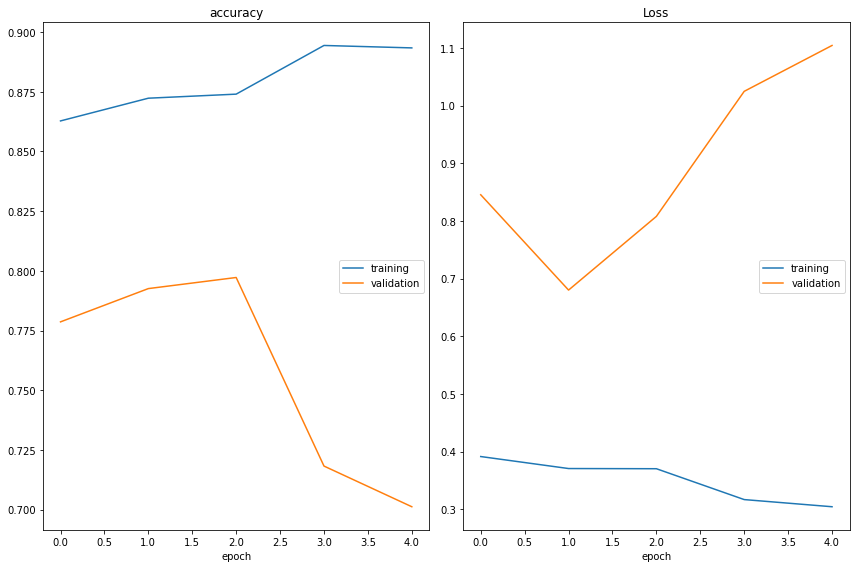

accuracy
	training         	 (min:    0.863, max:    0.894, cur:    0.893)
	validation       	 (min:    0.701, max:    0.797, cur:    0.701)
Loss
	training         	 (min:    0.305, max:    0.392, cur:    0.305)
	validation       	 (min:    0.680, max:    1.104, cur:    1.104)
92/92 [==============================] - 50s 543ms/step - loss: 0.3046 - accuracy: 0.8933 - val_loss: 1.1041 - val_accuracy: 0.7012
Saving history...
History saved :)


In [32]:
history_10 = complete_model.fit_generator(train_gen,
                                         steps_per_epoch=92,
                                         epochs=5,
                                         validation_data=val_gen,
                                         callbacks=[PlotLossesKeras()],
                                         verbose=1)

print("Saving history...")
with open('/kaggle/working/inceptionv3_hist_object_10', 'wb') as fi:
    pickle.dump(history.history, fi)

print("History saved :)")

In [33]:
complete_model.save('/kaggle/working/inceptionv3.h5')

# Model Visualization

In [80]:
layer_outputs = [layer.output for layer in complete_model.layers[:100]]
test_image = "../input/flowers-recognition/flowers/rose/2258973326_03c0145f15_n.jpg"
activation_model = Model(inputs=complete_model.input, outputs=layer_outputs)

In [81]:
img = image.load_img(test_image, target_size = (229,229))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 225.

In [82]:
activations = activation_model.predict(img_arr)

In [97]:
activations[1].shape

(1, 114, 114, 32)

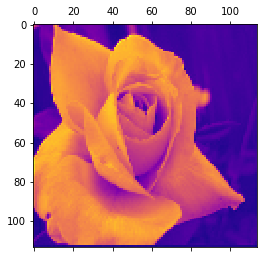

In [84]:
plt.matshow(activations[1][0, :, :, 1], cmap='plasma')
plt.show()

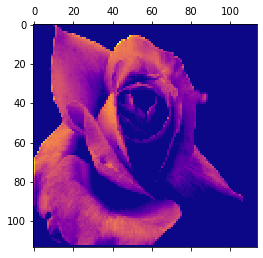

In [85]:
plt.matshow(activations[3][0, :, :, 1], cmap='plasma')
plt.show()

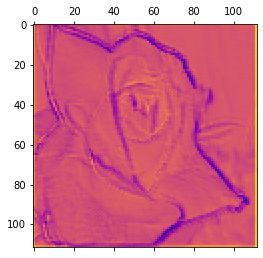

In [86]:
plt.matshow(activations[7][0, :, :, 1], cmap='plasma')
plt.show()

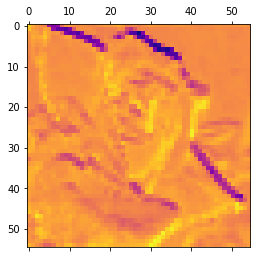

In [89]:
plt.matshow(activations[12][0, :, :, 5], cmap='plasma')
plt.show()

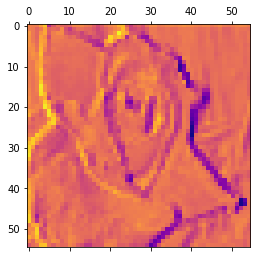

In [90]:
plt.matshow(activations[11][0, :, :, 20], cmap='plasma')
plt.show()

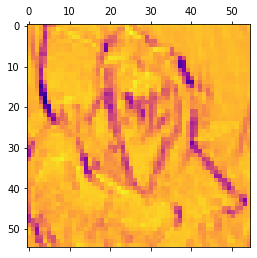

In [91]:
plt.matshow(activations[11][0, :, :, 40], cmap='plasma')
plt.show()

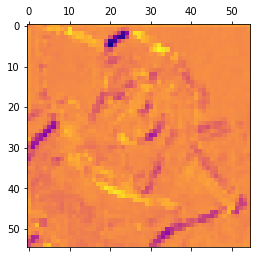

In [92]:
plt.matshow(activations[11][0, :, :, 79], cmap='plasma')
plt.show()

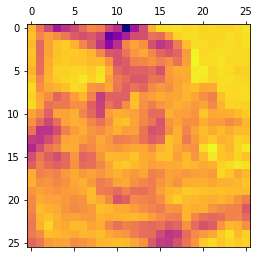

In [93]:
plt.matshow(activations[18][0, :, :, 1], cmap='plasma')
plt.show()

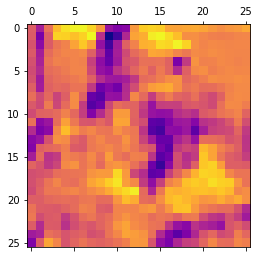

In [94]:
plt.matshow(activations[18][0, :, :, 20], cmap='plasma')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


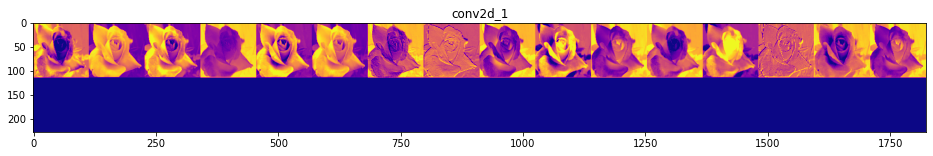

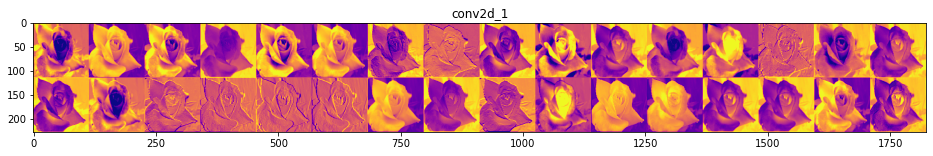

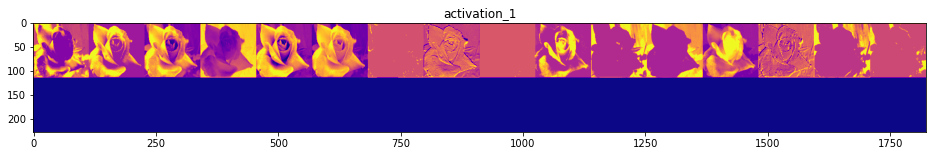

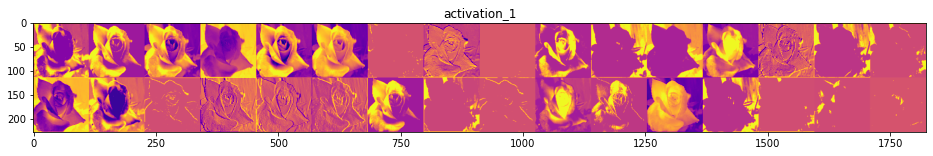

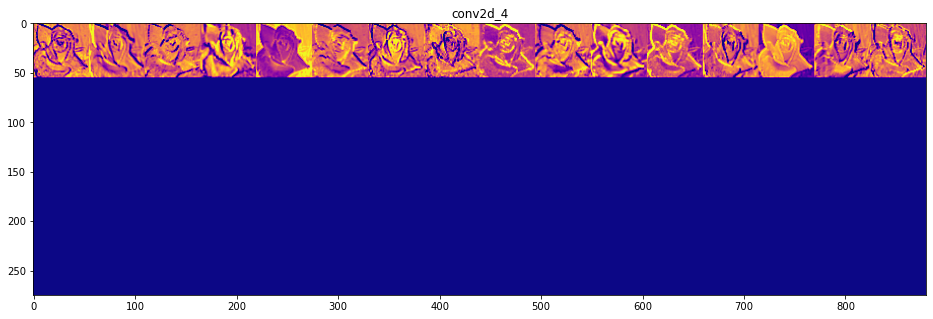

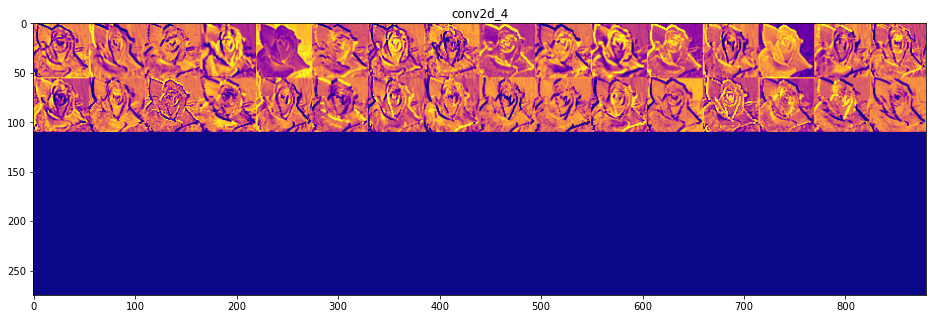

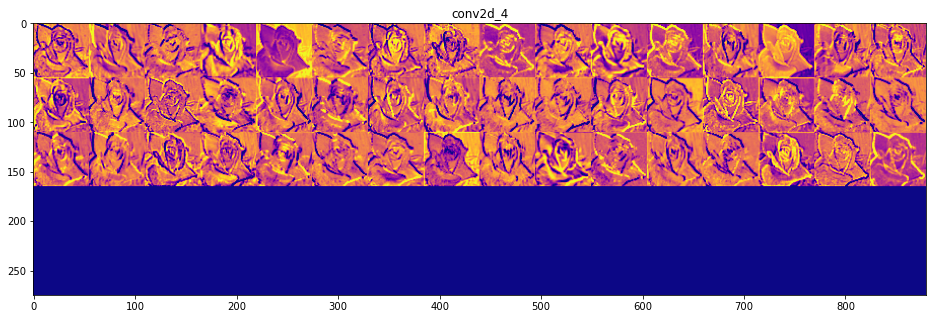

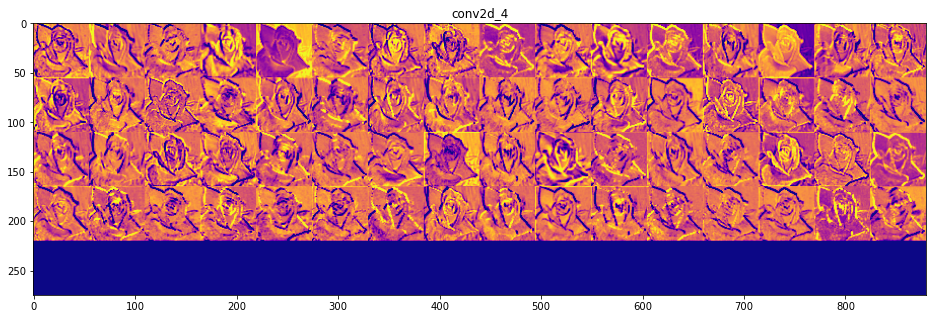

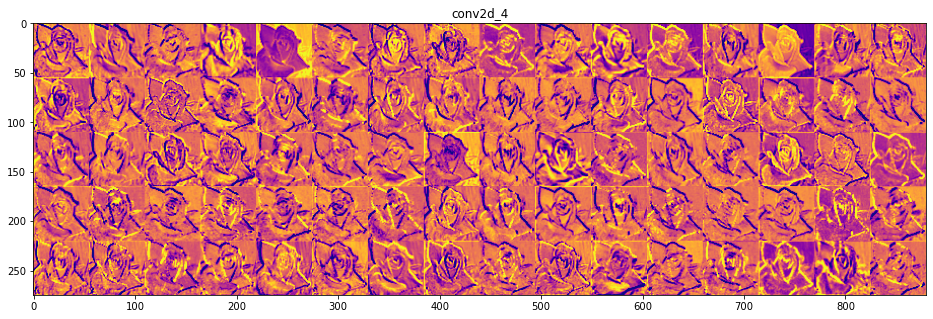

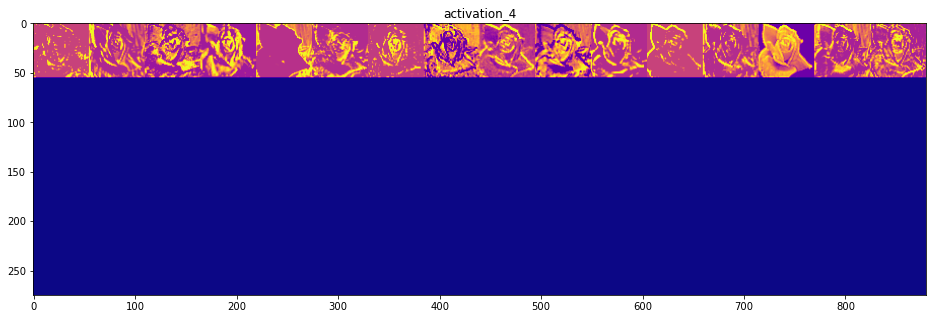

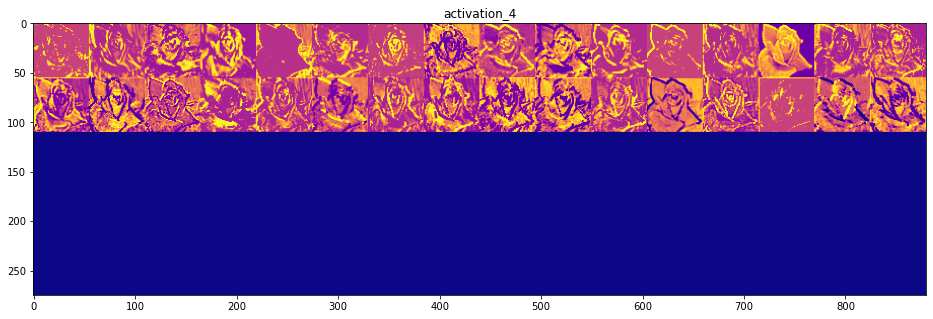

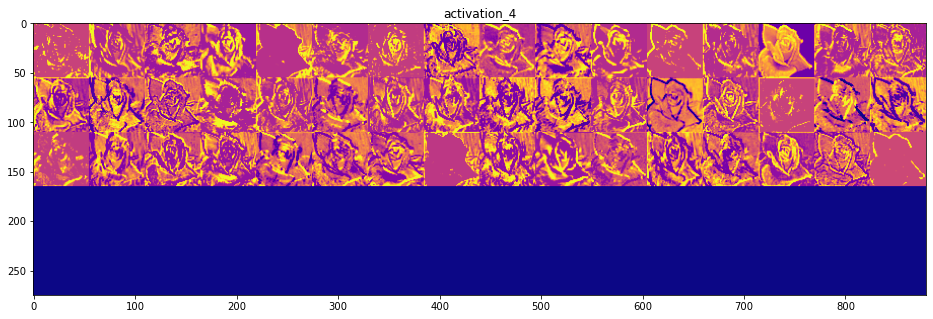

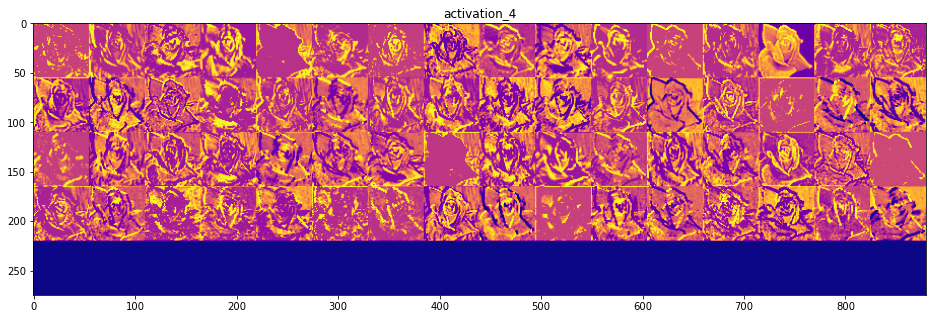

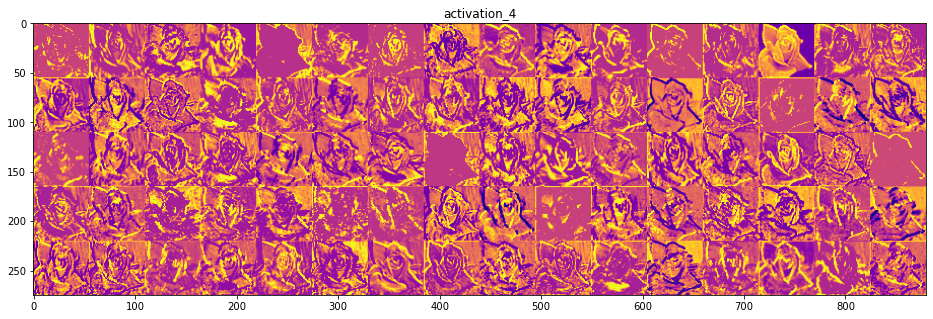

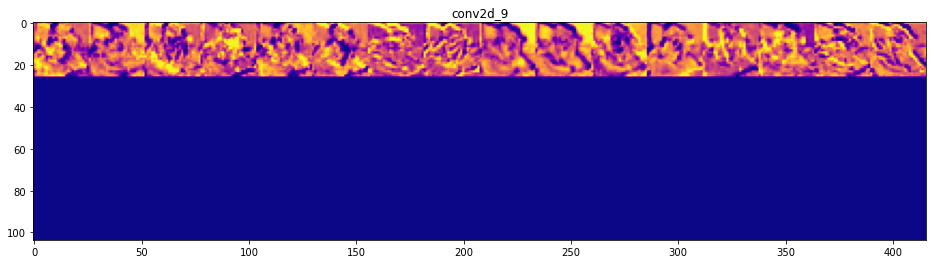

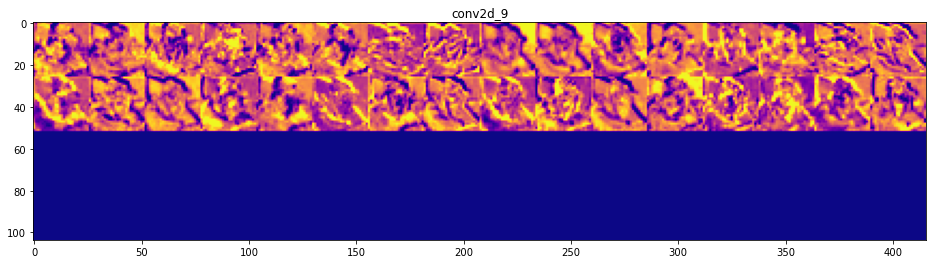

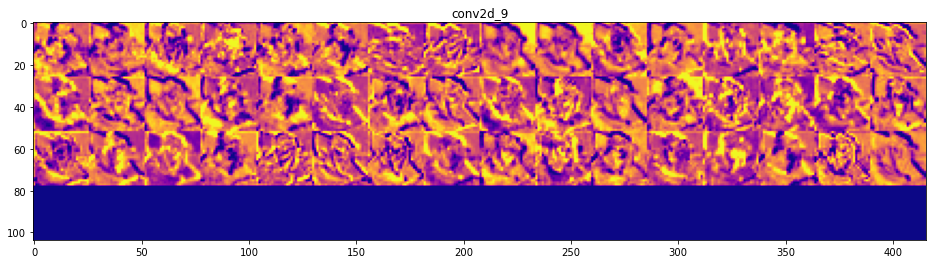

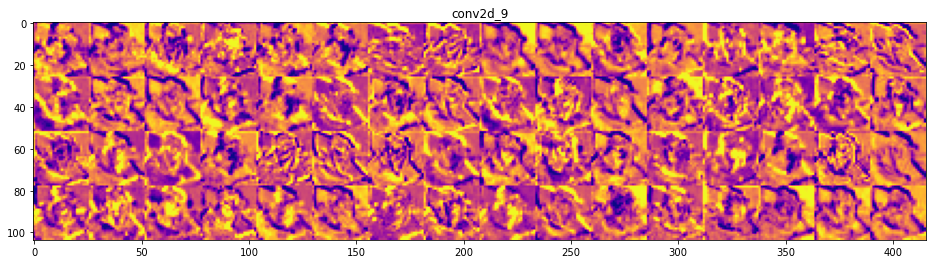

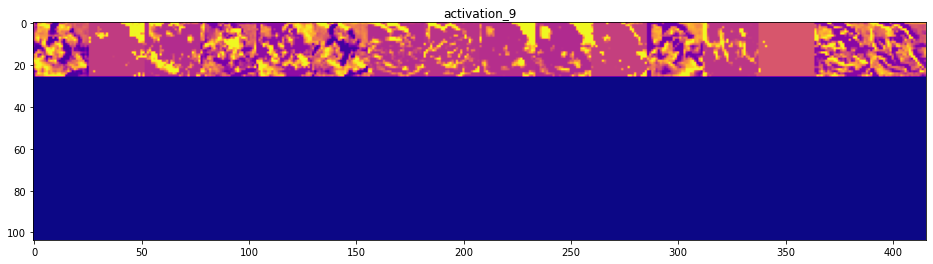

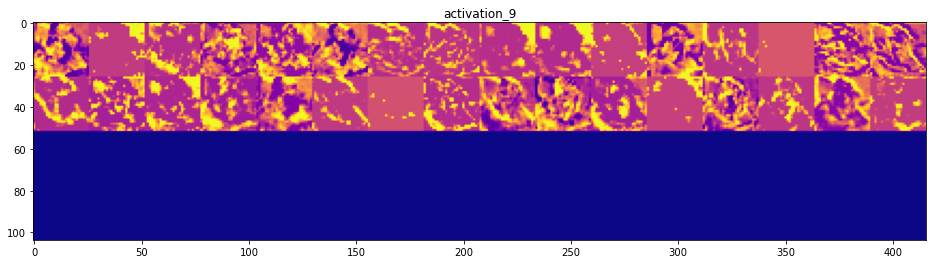

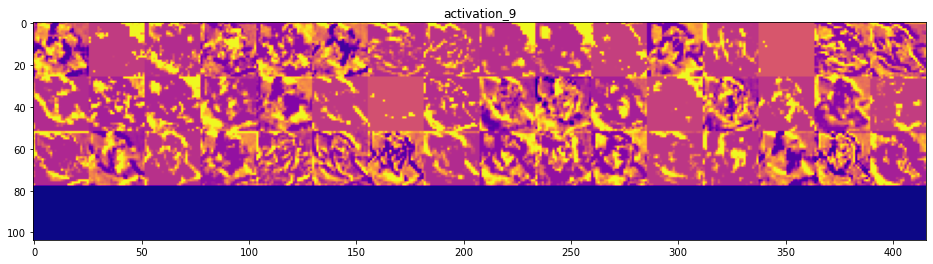

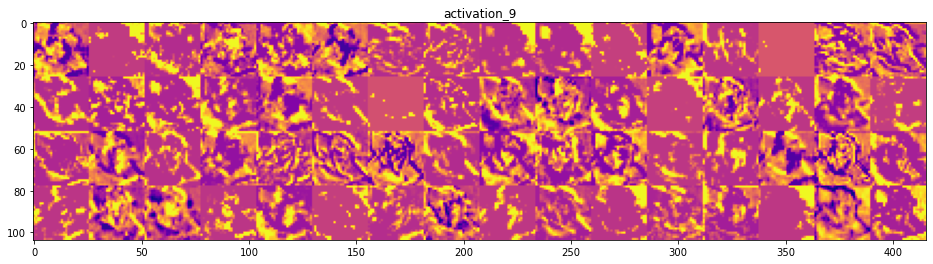

In [100]:
layer_names = ['conv2d_1', 
               'activation_1', 
               'conv2d_4', 
               'activation_4', 
               'conv2d_9', 
               'activation_9']

activ_list = [activations[1], 
              activations[3], 
              activations[11], 
              activations[13], 
              activations[18], 
              activations[20]]

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activ_list):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 225).astype('uint8')
            display_grid[col*size : (col+1)*size, row*size : (row+1)*size]=channel_image
            
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')
        plt.savefig("/kaggle/working/" + layer_name + "_grid.jpg", 
                    bbox_inches='tight')